## import Dependencies

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load data

In [4]:
df = pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [5]:
df.shape

(6000, 785)

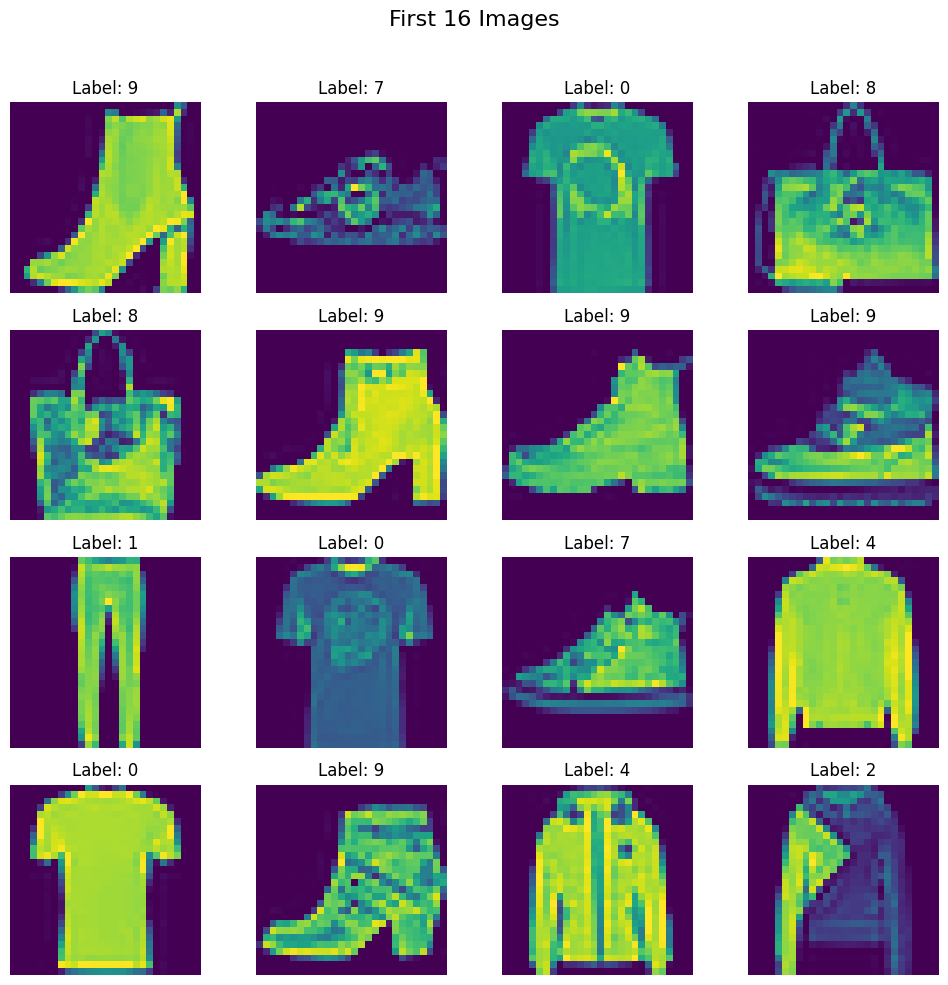

In [6]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

## Train test split

In [7]:
X = df.iloc[:, 1:].values  # Get all rows, and all columns after the first
y = df.iloc[:, 0].values  # Get all rows, and only the first column

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train = X_train/255.0
X_test = X_test/255.0

## Custom Dataset Class

In [9]:
class CustomDataset(Dataset):

    def __init__(self, features, labels):

        # Convert to pytorch Tensors
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.labels[index]


In [10]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [11]:
# train_loader = DataLoader(train_dataset, shuffle=True, pin_memory=True)
# test_loader = DataLoader(test_dataset, shuffle=True, pin_memory=True)
# len(train_loader)

## Model Class

In [12]:
# model class definition for hyperparameter tuning
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()
    layers = []

    for _ in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))
    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

## Define Objective Function

In [13]:
def objective(trial):

    # hyperparameter values from the search space
    # Hidden layers
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
    # neurons per layer
    neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128)
    # epochs
    epochs = trial.suggest_int("epochs", 10, 50, step=10)
    # learning rate
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    # dropout rate
    dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5, step=0.1)
    # batch size
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    # optimizer nme
    optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
    # weight decay
    weight_decay = trial.suggest_float("weight_decay",  1e-5, 1e-3, log=True)
    # define DataLoader objects here
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    # model init
    input_dim=784
    output_dim=10

    model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
    model.to(device)

    # optimizer selection
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

    if optimizer_name == 'Adam':
        optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


    # training loop
    for epoch in range(epochs):

        for batch_features, batch_labels in train_loader:

            # move data to gpu
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            # forward pass
            outputs = model(batch_features)
            # calculate loss
            loss = criterion(outputs, batch_labels)
            # back pass
            optimizer.zero_grad()
            loss.backward()
            # update grads
            optimizer.step()

    
    # evaluation
    model.eval()

    # evaluation on test data
    total = 0
    correct = 0

    with torch.no_grad():

        for batch_features, batch_labels in test_loader:
            # move data
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)

            total = total + batch_labels.shape[0]
            correct = correct + (predicted == batch_labels).sum().item()
            accuracy = correct/total

        return accuracy   

## Optuna Evaluation

In [14]:
!pip install optuna

In [15]:
import optuna
study = optuna.create_study(direction='maximize')

c:\Users\zisha\.conda\envs\env-nktorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-02-06 15:30:04,239] A new study created in memory with name: no-name-3867dbcf-16a6-479a-9b6c-623e5673ffec


In [16]:
study.optimize(objective, n_trials=10)

[I 2025-02-06 15:30:33,289] Trial 0 finished with value: 0.8308333333333333 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 71, 'epochs': 40, 'learning_rate': 0.0012361062714821036, 'dropout_rate': 0.30000000000000004, 'batch_size': 32, 'optimizer': 'Adam', 'weight_decay': 0.00010834875179363001}. Best is trial 0 with value: 0.8308333333333333.
[I 2025-02-06 15:30:40,881] Trial 1 finished with value: 0.7533333333333333 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 16, 'epochs': 40, 'learning_rate': 0.00791594726776441, 'dropout_rate': 0.30000000000000004, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 1.9265721671750607e-05}. Best is trial 0 with value: 0.8308333333333333.
[I 2025-02-06 15:30:49,308] Trial 2 finished with value: 0.8275 and parameters: {'num_hidden_layers': 2, 'neurons_per_layer': 45, 'epochs': 20, 'learning_rate': 0.0005912066470890125, 'dropout_rate': 0.1, 'batch_size': 32, 'optimizer': 'SGD', 'weight_decay': 0.000261794106565

In [17]:
study.best_value

0.8416666666666667

In [18]:
study.best_params

{'num_hidden_layers': 4,
 'neurons_per_layer': 116,
 'epochs': 40,
 'learning_rate': 0.0005310487692091441,
 'dropout_rate': 0.30000000000000004,
 'batch_size': 32,
 'optimizer': 'SGD',
 'weight_decay': 0.00019495129367911926}

In [19]:
!pip install nbformat --upgrade

In [20]:
import optuna
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_contour, plot_slice, plot_param_importances

# Plot optimization history
fig_optimization_history = plot_optimization_history(study)
fig_optimization_history.show()

# Plot parallel coordinate
fig_parallel_coordinate = plot_parallel_coordinate(study)
fig_parallel_coordinate.show()

# Plot contour
fig_contour = plot_contour(study)
fig_contour.show()

# Plot slice
fig_slice = plot_slice(study)
fig_slice.show()

# Plot hyperparameter importance
fig_param_importances = plot_param_importances(study)
fig_param_importances.show()